<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Download-Data" data-toc-modified-id="Download-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Download Data</a></span></li><li><span><a href="#Calculate-past-11-1-returns" data-toc-modified-id="Calculate-past-11-1-returns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate past 11-1 returns</a></span></li><li><span><a href="#Portfolio-Sorts" data-toc-modified-id="Portfolio-Sorts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Portfolio Sorts</a></span><ul class="toc-item"><li><span><a href="#Portfolio-Sorts" data-toc-modified-id="Portfolio-Sorts-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Portfolio Sorts</a></span></li><li><span><a href="#Rankdate-definition" data-toc-modified-id="Rankdate-definition-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Rankdate definition</a></span></li><li><span><a href="#Merge-data" data-toc-modified-id="Merge-data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Merge data</a></span></li><li><span><a href="#Calculate-returns" data-toc-modified-id="Calculate-returns-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Calculate returns</a></span></li></ul></li><li><span><a href="#Compare-with-Fama-and-French-(Ken-French-website)" data-toc-modified-id="Compare-with-Fama-and-French-(Ken-French-website)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare with Fama and French (Ken French website)</a></span><ul class="toc-item"><li><span><a href="#Correlation" data-toc-modified-id="Correlation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Time-series-plot" data-toc-modified-id="Time-series-plot-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Time series plot</a></span></li></ul></li></ul></div>

# Big Data in Finance: Part III <BR><BR>Homework 2: Momentum Factor
    
**Instructor** <BR>
Ritt Keerati, ritt.keerati@gsb.columbia.edu
    
**TA's:** <BR>
Meha Sadasivam, MSadasivam21@gsb.columbia.edu <BR>
Daheng Yang, dyang22@gsb.columbia.edu

## Setup

In [1]:
%matplotlib inline

# Packages 
import sys
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

import time
from time import strptime, strftime
from pandas.tseries.offsets import MonthEnd

# Setups
pd.set_option("display.max_rows", 100) # max number or rows to be displayed 
plt.rcParams['figure.figsize'] = [10, 6]
idx = pd.IndexSlice

In [2]:
# Packages from fire_pytools
sys.path.append("/Users/rk2941/Dropbox/courses/big_data_2022/fire_pytools")

# Data Import
from data_setup import stock_monthly
from data_setup import stock_annual

# Functions
from utils.monthly_date import *
from portools.find_breakpoints import find_breakpoints
from portools.sort_portfolios import sort_portfolios
from import_kf.kf_factors import *
from utils.post_event_nan import *

import warnings
warnings.filterwarnings('ignore')

## Download Data

In [3]:
# This is the same data we used in class. It use data download from CRSP
#mdata = stock_monthly.main()
#mdata.to_pickle(path = '/Users/rk2941/Dropbox/courses/big_data_2022/data/stock_monthly.pkl')
mdata = pd.read_pickle('/Users/rk2941/Dropbox/courses/big_data_2022/data/stock_monthly.pkl')

## Calculate past 11-1 returns

In [4]:
# Clean Data
## Data start in 1970
mdata = mdata[mdata.date>='1970-01-01']
## Share type - select only common stocks 
mdata = mdata[mdata.shrcd.isin([10, 11])]
## Select stocks traded on the major stock exchanges
mdata = mdata[mdata.exchcd.isin([1, 2, 3])]
## Set index
mdata.set_index(['permno','date'], inplace=True)

In [5]:
# Calculate excess returns
mdata['exret'] = mdata['retadj'] - mdata['rf']

In [6]:
# Calculate past returns 
def calculate_cumulative_returns(mdata, tt, min_periods):
    """
    Calculate past returns for momentum stratagy

    Parameters:
    ------------
    mdata: data frame
        crsp monthly data with cols permno, date as index.
    tt: int
        number of periods to cumulate retuns
    min_periods: int
    """
    start_time = time.time()
    required_cols = ['exret']

    assert set(required_cols).issubset(mdata.columns), "Required columns: {}.".format(', '.join(required_cols))

    df = mdata[required_cols].copy()

    # Before applying the function calculate_cumulative_returns you need to make sure 
    # we don't have missing dates. Missing dates would lead to the wrong number of periods 
    # to cumulate returns.

    # Resample data 
    # CRSP data has skipping months.
    # Create line to missing  months to facilitate the calculation of lag/past returns
    df.reset_index(inplace=True)
    df['edate'] = df['date'] + MonthEnd(0)
    df.sort_values(['permno', 'edate'], inplace=True)
    pk_integrity(df, ['permno', 'edate'])
    df.set_index(['edate'], inplace=True)
    # Resample to take care of missing months
    sdf = df[['permno', 'exret']].groupby('permno').resample('M').mean().drop(columns='permno')
    sdf.reset_index(inplace=True)
    print("Time to resample data: %s seconds" % str(time.time() - start_time))
    print("We have added %s rows to the data" % str(sdf.shape[0] - df.shape[0]))

    # Cumulative Return (adjusted) in tt months
    sdf['gret'] = sdf['exret'].fillna(0)+1
    sdf['ret_notnull'] = sdf['exret'].notnull()

    cret = sdf.groupby(['permno']).gret.rolling(window=tt, min_periods=1).apply(np.prod, raw=True)
    cret.reset_index(drop=True, inplace=True)

    nona_count = sdf.groupby(['permno']).ret_notnull.rolling(window=tt, min_periods=1).apply(np.sum, raw=True)
    nona_count.reset_index(drop=True, inplace=True)

    cret[nona_count<min_periods] = np.nan
    sdf['ret' + str(tt)] = cret

    # Delete rows that were not in the original data set
    df.reset_index(inplace=True)
    fdata = pd.merge(df,
             sdf[['edate', 'permno','ret' + str(tt)]],
             on = ['edate', 'permno'])         
    fdata.set_index(['permno','date'],inplace = True)
    x = fdata['ret' + str(tt)]

    print("Time to calculate %d months past returns: %s seconds" % (tt, str(round(time.time() - start_time, 2))))

    return x

In [7]:
## Calculate 11 months returns
mdata['ret11'] = calculate_cumulative_returns(mdata, 11, 8)

Time to resample data: 68.78757405281067 seconds
We have added 68342 rows to the data
Time to calculate 11 months past returns: 96.09 seconds


In [8]:
## Skip one month 
mdata['ret11_1'] = mdata.groupby(['permno']).ret11.shift(1)

In [9]:
# Create MEsum: when sorting by size this is the ME to be used
mdata['mesum'] = mdata.groupby(['date', 'permco']).me.transform(np.sum, min_count=1)

## Portfolio Sorts

### Portfolio Sorts

In [10]:
# Clean data
sort_data = mdata[mdata.ret11_1.notnull()]
sort_data = sort_data[sort_data.mesum.notnull()]

# Reset index
mdata.reset_index(inplace=True)

In [11]:
port = sort_portfolios(data = sort_data,
                       quantiles={'mesum': [0.5],
                                  'ret11_1': [0.3, 0.7]},
                       id_variables=['date', 'permno', 'exchcd'],
                       exch_cd=[1])

NYSE breakpoints were calculated for mesum.
Stocks were sorted according to breakpoints, starting in 1970-09-30 00:00:00
NYSE breakpoints were calculated for ret11_1.
Stocks were sorted according to breakpoints, starting in 1970-09-30 00:00:00


### Rankdate definition

In [14]:
# Create rankdate variable to merge with stock file
port['rankdate'] = port.date.dt.year * 100 + port.date.dt.month

port.drop(columns='date', inplace=True)

In [15]:
# Create rankdate variable to merge with portfolio sort
mdata['rankdate'] = mdata['date'] - pd.Timedelta('35 days')

mdata['rankdate'] = mdata.rankdate.dt.year * 100 + mdata.rankdate.dt.month

### Merge data

In [16]:
fdata = pd.merge(mdata[['permno', 'date', 'rankdate', 'retadj', 'lag_me', 'ticker']], 
                port,
                on = ['permno', 'rankdate'])

Have a look at Apple in 2019. Which portfolio did Apple belong to?

In [17]:
fdata[(fdata.ticker=='AAPL') & (fdata.date.dt.year==2019)]

,permno,date,rankdate,retadj,lag_me,ticker,ret11_1portfolio,mesumportfolio
322224,14593,2019-01-31,201812,0.055154,7.460792e+05,AAPL,ret11_12,mesum2
322225,14593,2019-02-28,201901,0.044701,7.848112e+05,AAPL,ret11_12,mesum2
322226,14593,2019-03-29,201902,0.097026,8.164507e+05,AAPL,ret11_12,mesum2
322227,14593,2019-04-30,201903,0.056436,8.956674e+05,AAPL,ret11_12,mesum2
322228,14593,2019-05-31,201904,-0.123735,9.232977e+05,AAPL,ret11_13,mesum2
322229,14593,2019-06-28,201905,0.130519,8.055102e+05,AAPL,ret11_12,mesum2
322230,14593,2019-07-31,201906,0.076394,8.968537e+05,AAPL,ret11_12,mesum2
322231,14593,2019-08-30,201907,-0.016570,9.627661e+05,AAPL,ret11_12,mesum2
322232,14593,2019-09-30,201908,0.072962,9.433337e+05,AAPL,ret11_12,mesum2
322233,14593,2019-10-31,201909,0.110684,9.951516e+05,AAPL,ret11_12,mesum2


### Calculate returns

In [18]:
fdata.retadj.notnull().mean()

0.9992668559830881

In [19]:
fdata = fdata[fdata.retadj.notnull()]

In [20]:
fdata

,permno,date,rankdate,retadj,lag_me,ticker,ret11_1portfolio,mesumportfolio
0,10000,1986-11-28,198610,0.060000,3.002344e+00,OMFGA,ret11_11,mesum1
1,10000,1986-12-31,198611,-0.377358,3.182484e+00,OMFGA,ret11_11,mesum1
2,10000,1987-01-30,198612,-0.212121,1.981547e+00,OMFGA,ret11_11,mesum1
3,10000,1987-02-27,198701,0.000000,1.581531e+00,OMFGA,ret11_11,mesum1
4,10000,1987-03-31,198702,-0.384615,1.581531e+00,OMFGA,ret11_11,mesum1
...,...,...,...,...,...,...,...,...
2843911,93436,2021-08-31,202107,0.070605,6.803383e+05,TSLA,ret11_13,mesum2
2843912,93436,2021-09-30,202108,0.054042,7.370200e+05,TSLA,ret11_12,mesum2
2843913,93436,2021-10-29,202109,0.436530,7.785819e+05,TSLA,ret11_12,mesum2
2843914,93436,2021-11-30,202110,0.027612,1.118751e+06,TSLA,ret11_13,mesum2


In [21]:
ret = fdata.groupby(['date', 
                     'mesumportfolio', 
                     'ret11_1portfolio']).apply(lambda x: np.average(x['retadj'], 
                                                                weights = x['lag_me']))

In [22]:
ret = ret.unstack(level=[1, 2])

<AxesSubplot:xlabel='date'>

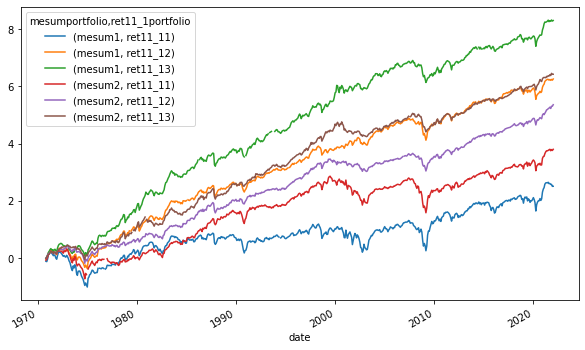

In [23]:
np.log(1+ret).cumsum().plot()

In [24]:
ret

mesumportfolio      mesum1                        mesum2                    
ret11_1portfolio  ret11_11  ret11_12  ret11_13  ret11_11  ret11_12  ret11_13
date                                                                        
1970-10-30       -0.108311 -0.032706 -0.003526 -0.071985 -0.009034 -0.008271
1970-11-30       -0.008591  0.027862  0.027413  0.043484  0.052768  0.059474
1970-12-31        0.096765  0.088479  0.087699  0.070133  0.070353  0.044860
1971-01-29        0.150844  0.101969  0.090199  0.102374  0.048239  0.032106
1971-02-26        0.043734  0.031622  0.042867  0.004361  0.010449  0.021424
...                    ...       ...       ...       ...       ...       ...
2021-08-31        0.004799  0.021244  0.031848  0.015570  0.033683  0.047769
2021-09-30       -0.033504 -0.028109 -0.018957 -0.049463 -0.044251 -0.030973
2021-10-29        0.003577  0.032508  0.047792  0.043100  0.081226  0.081407
2021-11-30       -0.066439 -0.026030 -0.036975 -0.031700  0.000501 -0.030554
2021-12-31        0.002458  0.042995  0.018953  0.042099  0.054086 -0.001083

[615 rows x 6 columns]

In [25]:
ret.loc[:, idx[:, 'ret11_13']]

mesumportfolio,mesum1,mesum2
ret11_1portfolio,ret11_13,ret11_13
date,,
1970-10-30,-0.003526,-0.008271
1970-11-30,0.027413,0.059474
1970-12-31,0.087699,0.044860
1971-01-29,0.090199,0.032106
1971-02-26,0.042867,0.021424
...,...,...
2021-08-31,0.031848,0.047769
2021-09-30,-0.018957,-0.030973


In [26]:
mom = ret.loc[:, idx[:, 'ret11_13']].mean(axis=1)-ret.loc[:, idx[:, 'ret11_11']].mean(axis=1)

<AxesSubplot:xlabel='date'>

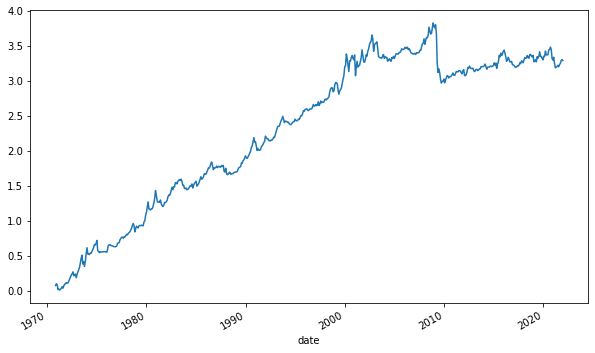

In [27]:
np.log(1+mom).cumsum().plot()

## Compare with Fama and French (Ken French website)

In [28]:
# Import MOM from Ken French website
ff = pd.read_csv('/Users/rk2941/Dropbox/courses/big_data_2022/homeworks/hw_ii/F-F_Momentum_Factor.CSV', skiprows=14, skipfooter=100,names=['mdate','Mom'], on_bad_lines='skip')


In [29]:
ff['mom_ff'] = ff['Mom']/100

In [30]:
# Set up our data
mom=mom.to_frame('mom')
mom.reset_index(inplace=True)
mom['mdate'] = mom.date.dt.year*100 + mom.date.dt.month

In [31]:
# Merge 
mom = pd.merge(mom, ff[['mdate', 'mom_ff']])

In [32]:
mom.drop(columns='mdate', inplace=True)

In [33]:
mom.set_index('date', inplace=True)

### Correlation

In [34]:
mom.corr()

,mom,mom_ff
mom,1.000000,0.996041
mom_ff,0.996041,1.000000


### Time series plot

<AxesSubplot:xlabel='date'>

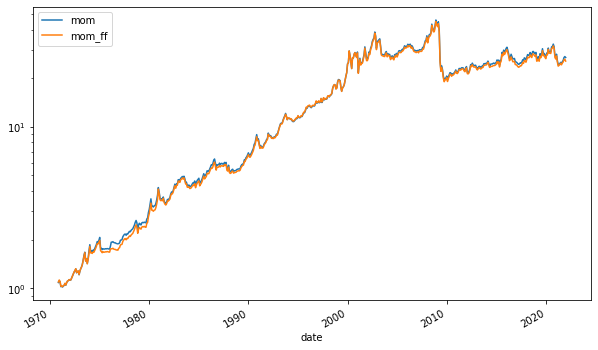

In [35]:
((1+mom[['mom','mom_ff']]).cumprod()).plot(logy=True)